Compute the DMM and PA statistics for a specified region in the Med.

Data are from three WRF numerical simulations of the medicane Ianos (15-20 Sep 2020) with different PBL schemes performed by Elenio Avolio (e.avolio@isac.cnr.it). DMM and PA metrics are defined in Meroni et al. JGRA (2022), https://doi.org/10.1029/2021JD035968.

In [1]:
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import xarray as xr
import pandas as pd
import glob
import geometry as gm # grad_sphere, div_sphere, nan_gaussian_filter
import distributions as dstr

In [2]:
crs = ccrs.PlateCarree()
def plot_background(ax):
    #ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    #ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

In [36]:
# Set the path to the specific experiment.
exp = 'test4' # 'test1', 'test3', 'test4'
path2wrfout = '/home/agostino/air-sea_medicane/data/'

In [37]:
# Set the standard deviation of the Gaussian filter to be used to evaluate the background wind.
sigma = 10 # sigma = 50 # 500 km, dx = 10 km in these simulations.

In [38]:
def nonlinear_metrics(x,y,n,threshold):
    """
    Compute the linear regression line for the central 90% of points of the distribution.
    With this, compute the mean signed difference between the y and the linear fit, to measure the nonlinearity.
    x and y are the variables of interest [S.I. units] and n is the number of points for each value of x.
    The ratio of the areas under the linear fit and the experimental points are computed.
    threshold indicates the minimum number of points that a bin has to contain in order to be used for the 
    computation of the area ratios.
    """
    from scipy import stats

    # Define the 5th and 95th percentiles of x, named x5 and x95, expoiting the information in n.
    ntot = np.sum(n)
    cdf = np.cumsum(n)/ntot
    i5 = np.argmin(np.abs(cdf-0.05))
    i95 = np.argmin(np.abs(cdf-0.95))
    x5 = x[i5]
    x95 = x[i95]

    # Perform the linear regression over this subset of points.
    sub_x = x[(x>=x5)&(x<=x95)]
    sub_y = y[(x>=x5)&(x<=x95)]
    sub_lsq_res = stats.linregress(sub_x, sub_y)
    sub_slope = sub_lsq_res[0]
    sub_intercept = sub_lsq_res[1]
    sub_y_fit = sub_slope*x+sub_intercept
    sub_slope_p = sub_lsq_res[3]

    # Compute the mean differences.
    mdiff = np.mean(y-sub_y_fit)
    mdiff_negx = np.mean(y[x<0]-sub_y_fit[x<0])
    mdiff_posx = np.mean(y[x>0]-sub_y_fit[x>0])
    
    # Compute the areas under the data points and the area of the linear relationship, for the positive and 
    # negative x separately. Then compute their ratio.
    #dx = x[round(len(x)/2)]-x[round(len(x)/2)-1]
    #ipsilon = y[n>threshold]
    #ics = x[n>threshold]
    #r_negx = -2*np.mean(ipsilon[ics<0]-sub_intercept)/(len(ipsilon[ics<0])*dx*sub_slope)
    #r_posx = 2*np.mean(ipsilon[ics>0]-sub_intercept)/(len(ipsilon[ics>0])*dx*sub_slope)
    r_negx = np.nan
    r_posx = np.nan

    return sub_slope, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx, r_posx, sub_slope_p

In [39]:
# Select here the fields to be analysed.
mech = 'DMM' # 'DMM', 'PA'
if mech=='DMM':
    str_a = 'dsst_dr' # Choose between: 'gamma', 'dsst_dr', 'lapl_sst', 'd2sst_ds2'
    str_b = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds'
    alpha_units = 'm s$^{-1}$ K$^{-1}$' # 'm s$^{-1}$ K$^{-1}$' or 'm$^2$ s$^{-1}$ K$^{-1}$'
elif mech=='PA':
    str_a = 'd2sst_ds2' # Choose between: 'gamma', 'dsst_dr', 'lapl_sst', 'd2sst_ds2'
    str_b = 'ds_dot_prime_ds' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds'
    alpha_units = 'm$^2$ s$^{-1}$ K$^{-1}$' # 'm s$^{-1}$ K$^{-1}$' or 'm$^2$ s$^{-1}$ K$^{-1}$'
    
plot_wind_sst = False
plot_maps = False

#extent_zoom = [20,40,30,40]

In [40]:
# Loop on time.
str_start = '2020-09-15T00:00:00'
str_end = '2020-09-20T00:00:00'

instant = np.datetime64(str_start) # Initialize the loop.
a = []
b = []
tt = 0

threshold_number = 1e3

# Read the coordinates and the angles to rotate the wind components as described in  
# http://www-k12.atmos.washington.edu/~ovens/wrfwinds.html

file_coords = 'wrfout_d01_2020-09-15_00:00:00'
ds_c = xr.open_dataset(path2wrfout+file_coords)

lon = ds_c.XLONG[0].values
lat = ds_c.XLAT[0].values
sinalpha = ds_c.SINALPHA[0].values # This is small, 0(0.1), and around zero.
cosalpha = ds_c.COSALPHA[0].values # This is slightly smaller than 1.
extent = [np.min(lon),np.max(lon),np.min(lat),np.max(lat)]

lakemask = ds_c.LAKEMASK[0].values
landmask = ds_c.LANDMASK[0].values
seamask = 1-landmask-lakemask
maxshift = 2 # dx=10 km
for ss in range(maxshift):
    seamask_sw = np.roll(seamask,-(ss+1),axis=[0,1])
    seamask_ne = np.roll(seamask,ss+1,axis=[0,1])
    seamask_nw = np.roll(seamask,[ss+1,-(ss+1)],axis=[0,1])
    seamask_se = np.roll(seamask,[-(ss+1),ss+1],axis=[0,1])
    seamask = seamask_sw*seamask_ne*seamask_nw*seamask_se
seamask /= seamask

a_timeavg = np.zeros_like(lon)
b_timeavg = np.zeros_like(lon)

ts_slope = []
ts_p_slope = []
ts_sr = []
ts_p_sr = []
ts_slope_sub = []
ts_p_slope_sub = []

while instant<=np.datetime64(str_end):
    print(instant)
    pd_instant = pd.to_datetime(instant)
    year_oi = str(pd_instant.year).zfill(4)
    month_oi = str(pd_instant.month).zfill(2)
    day_oi = str(pd_instant.day).zfill(2)
    hour_oi = str(pd_instant.hour).zfill(2)
    
    ds = xr.open_dataset(path2wrfout+exp+'/wrfout_d01_'+year_oi+'-'+month_oi+'-'+day_oi+'_'+hour_oi+'_00_00')

    u10_wrf = ds.U10[0].values
    v10_wrf = ds.V10[0].values
    u10 = u10_wrf*cosalpha - v10_wrf*sinalpha
    v10 = v10_wrf*cosalpha + u10_wrf*sinalpha
    wspd = np.sqrt(u10**2+v10**2)
    
    sst = ds.SST[0].values

    # Get the background wind field.
    smooth_u = gm.nan_gaussian_filter(u10*seamask,sigma)
    smooth_v = gm.nan_gaussian_filter(v10*seamask,sigma)
    smooth_ws = np.sqrt(smooth_u**2+smooth_v**2)
    
    cosphi = smooth_u/smooth_ws
    sinphi = smooth_v/smooth_ws

    # Get the anomalies with respect to the background wind field.
    u_prime = u10-smooth_u
    v_prime = v10-smooth_v
    
    dsst_dx, dsst_dy = gm.grad_sphere(sst*seamask,lon,lat)
    if str_a=='gamma':
        a_prime = u10*dsst_dx + v10*dsst_dy
        x_string = 'u.grad(SST) [K/s]'; vmin_a=-2.2e-4; vmax_a=2.2e-4
    elif str_a=='dsst_dr':
        a_prime = dsst_dx*cosphi + dsst_dy*sinphi
        x_string = 'dSST/dr [K/m]'; vmin_a=-5e-5; vmax_a=5e-5
    elif str_a=='lapl_sst':
        a_prime = gm.div_sphere(dsst_dx,dsst_dy,lon,lat)
        x_string = 'lapl SST [K/m^2]'; vmin_a=-1e-9; vmax_a=1e-9
    elif str_a=='d2sst_ds2':
        dsst_ds = -dsst_dx*sinphi + dsst_dy*cosphi
        ddsst_ds_dx, ddsst_ds_dy = gm.grad_sphere(dsst_ds,lon,lat)
        a_prime = -ddsst_ds_dx*sinphi + ddsst_ds_dy*cosphi
        x_string = 'd2SST/ds2 [K/m^2]'; vmin_a=-5e-9; vmax_a=5e-9

    if str_b=='wind_div':
        b_prime = gm.div_sphere(u10,v10,lon,lat)
        y_string = 'Wind divergence [1/s]'; vmin_b=-2.2e-4; vmax_b=2.2e-4
    elif str_b=='dr_dot_prime_dr':
        r_dot_prime = u_prime*cosphi + v_prime*sinphi
        dr_dot_prime_dx, dr_dot_prime_dy = gm.grad_sphere(r_dot_prime,lon,lat)
        b_prime = dr_dot_prime_dx*cosphi + dr_dot_prime_dy*sinphi 
        y_string = 'dr dot prime/dr [1/s]'; vmin_b=-1e-4; vmax_b=1e-4#vmin_b=-2.2e-4; vmax_b=2.2e-4
    elif str_b=='ds_dot_prime_ds':
        s_dot_prime = -u_prime*sinphi + v_prime*cosphi
        ds_dot_prime_dx, ds_dot_prime_dy = gm.grad_sphere(s_dot_prime,lon,lat)
        b_prime = -ds_dot_prime_dx*sinphi + ds_dot_prime_dy*cosphi
        y_string = 'ds dot prime/ds [1/s]'; vmin_b=-1e-4; vmax_b=1e-4#vmin_b=-2.2e-5; vmax_b=2.2e-5

    if plot_wind_sst:
        # Plot wind speed and SST.
        from matplotlib import cm
        plasma20 = cm.get_cmap('plasma', 20)
        viridis20 = cm.get_cmap('viridis', 20)

        fig = plt.figure(figsize=(14,10),facecolor='white')

        ax0 = fig.add_subplot(2, 1, 1, projection=crs)
        plot_background(ax0)
        pc0 = ax0.pcolormesh(lon,lat,wspd,vmin=0,vmax=20,shading='nearest',
                           transform=ccrs.PlateCarree(),cmap=plasma20)
        step = 20
        ax0.barbs(lon[::step,::step],lat[::step,::step],u10[::step,::step],v10[::step,::step],length=6)
        cbar0 = plt.colorbar(pc0)
        cbar0.ax.tick_params(labelsize=12) 
        cbar0.set_label('Wind speed [m/s]',size=14)
        ax0.set_extent(extent)

        ax1 = fig.add_subplot(2, 1, 2, projection=crs)
        plot_background(ax1)
        #ax1.contour(lon,lat,(sst-273.15)*sstmask,levels=np.arange(0,30),colors='w',transform=ccrs.PlateCarree())
        pc1 = ax1.pcolormesh(lon,lat,(sst-273.15)*seamask,vmin=20,vmax=30,shading='nearest',
                             transform=ccrs.PlateCarree(),cmap=viridis20)
        cbar1 = plt.colorbar(pc1)
        cbar1.ax.tick_params(labelsize=12) 
        cbar1.set_label('SST [°C]',size=14)
        ax1.set_extent(extent)
        ax1.set_title(str(instant),fontsize=14)

        figure_name = 'wind_sst_map_' + "{:03}".format(tt) + '_'+exp+ '.png'
        plt.savefig('./figures/'+figure_name,bbox_inches='tight')
   
    if plot_maps:
        # Plot the two fields.
        fig = plt.figure(figsize=(14,10))

        ax0 = fig.add_subplot(2, 1, 1, projection=crs)
        plot_background(ax0)
        pc0 = ax0.pcolormesh(lon,lat,a_prime,vmin=vmin_a,vmax=vmax_a,shading='nearest',
                           transform=ccrs.PlateCarree(),cmap='seismic')
        step = 20
        ax0.barbs(lon[::step,::step],lat[::step,::step],u10[::step,::step],v10[::step,::step],length=6)
        cbar0 = plt.colorbar(pc0)
        cbar0.ax.tick_params(labelsize=12) 
        cbar0.set_label(x_string,size=14)
        #ax0.set_extent(extent_zoom)

        ax1 = fig.add_subplot(2, 1, 2, projection=crs)
        plot_background(ax1)
        #ax1.contour(lon,lat,(sst-273.15)*sstmask,levels=np.arange(0,30),colors='w',transform=ccrs.PlateCarree())
        pc1 = ax1.pcolormesh(lon,lat,b_prime,vmin=vmin_b,vmax=vmax_b,shading='nearest',
                             transform=ccrs.PlateCarree(),cmap='seismic')
        cbar1 = plt.colorbar(pc1)
        cbar1.ax.tick_params(labelsize=12) 
        cbar1.set_label(y_string,size=14)
        #ax1.set_extent(extent_zoom)

        figure_name = str_a+'_'+str_b+'_' + "{:03}".format(tt) + '_sigma'+str(sigma)+'_'+exp+ '.png'
        plt.savefig('./figures/'+figure_name,bbox_inches='tight')

    # Save to compute the time averaged fields.
    a_timeavg += a_prime
    b_timeavg += b_prime
    
    # Crop over the area of interest.
    a_sub = gm.crop_field(a_prime,lon,lat,extent)#_zoom)
    b_sub = gm.crop_field(b_prime,lon,lat,extent)#_zoom)
    
    # Concatenate the variables of interest.
    a_to_be_concat = a_sub[(~np.isnan(a_sub))&(~np.isnan(b_sub))]
    b_to_be_concat = b_sub[(~np.isnan(a_sub))&(~np.isnan(b_sub))]
    
    a = np.concatenate((a,a_to_be_concat))
    b = np.concatenate((b,b_to_be_concat))

    # Compute the instantaneous distributions.
    perc_step = 5
    out_fb = dstr.metrics_fixed_bin_distribution(a_to_be_concat,b_to_be_concat,perc_step)
    slope_t = out_fb[0]
    sr_distr_t = out_fb[2]
    p_value_t = out_fb[3]
    p_slope_t = out_fb[8]
    distribution_control_t = out_fb[4]
    distribution_t = out_fb[5]
    number_values_t = out_fb[9]
    
    ts_slope.extend([slope_t])
    ts_p_slope.extend([p_slope_t])
    ts_sr.extend([sr_distr_t])
    ts_p_sr.extend([p_value_t])
    
    # Compute the slopes considering the central 90 percent of points only.
    out_nl = nonlinear_metrics(distribution_control_t,distribution_t,number_values_t, threshold_number)
    sub_slope_t = out_nl[0]
    sub_intercept = out_nl[1]
    mdiff = out_nl[2]
    mdiff_negx = out_nl[3]
    mdiff_posx = out_nl[4]
    x5 = out_nl[5]
    x95 = out_nl[6]
    r_negx = out_nl[7]
    r_posx = out_nl[8]
    sub_slope_p_t = out_nl[9]
    
    ts_slope_sub.extend([sub_slope_t])
    ts_p_slope_sub.extend([sub_slope_p_t])
    
    tt += 1
    instant += np.timedelta64(1,'h')

    
# Time-averaged quantities are saved over the entire domain, whereas hourly fields are saved in the extent_zoom
# area of interest only.
nvalues = tt
a_timeavg = a_timeavg/nvalues
b_timeavg = b_timeavg/nvalues

file2save_timeavg = 'time_avg_'+str_a+'_'+str_b+'_'+exp+'.nc'
ds_2save = xr.Dataset({'a_timeavg': (('x', 'y'), a_timeavg),
                       'b_timeavg': (('x', 'y'), b_timeavg)}, 
                      coords={'lon':(('x','y'),lon),
                              'lat':(('x','y'),lat)})
ds_2save.to_netcdf(file2save_timeavg, 'w')

# Save the time series
ts_slope = np.array(ts_slope)
ts_p_slope = np.array(ts_p_slope)
ts_sr = np.array(ts_sr)
ts_p_sr = np.array(ts_p_sr)
ts_slope_sub = np.array(ts_slope_sub)
ts_p_slope_sub = np.array(ts_p_slope_sub)

file2save = 'time_series_slope_' + str_a + '_' + str_b + '_'+exp+ '.txt'
d = {'ts_slope':np.transpose(ts_slope), 
     'ts_p_slope':np.transpose(ts_p_slope),
     'ts_sr':np.transpose(ts_sr), 
     'ts_p_sr':np.transpose(ts_p_sr),
     'ts_slope_sub':np.transpose(ts_slope_sub), 
     'ts_p_slope_sub':np.transpose(ts_p_slope_sub)}
df = pd.DataFrame(data=d)
df.to_csv(file2save, index=False)

<ipython-input-40-5eb50af19d0a>:34: RuntimeWarning: invalid value encountered in true_divide
  seamask /= seamask
/home/agostino/air-sea_medicane/geometry.py:77: RuntimeWarning: divide by zero encountered in true_divide
  zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field
/home/agostino/air-sea_medicane/geometry.py:77: RuntimeWarning: invalid value encountered in true_divide
  zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field
<ipython-input-40-5eb50af19d0a>:69: RuntimeWarning: invalid value encountered in true_divide
  cosphi = smooth_u/smooth_ws
<ipython-input-40-5eb50af19d0a>:70: RuntimeWarning: invalid value encountered in true_divide
  sinphi = smooth_v/smooth_ws


2020-09-15T00:00:00
2020-09-15T01:00:00
2020-09-15T02:00:00
2020-09-15T03:00:00
2020-09-15T04:00:00
2020-09-15T05:00:00
2020-09-15T06:00:00
2020-09-15T07:00:00
2020-09-15T08:00:00
2020-09-15T09:00:00
2020-09-15T10:00:00
2020-09-15T11:00:00
2020-09-15T12:00:00
2020-09-15T13:00:00
2020-09-15T14:00:00
2020-09-15T15:00:00
2020-09-15T16:00:00
2020-09-15T17:00:00
2020-09-15T18:00:00
2020-09-15T19:00:00
2020-09-15T20:00:00
2020-09-15T21:00:00
2020-09-15T22:00:00
2020-09-15T23:00:00
2020-09-16T00:00:00
2020-09-16T01:00:00
2020-09-16T02:00:00
2020-09-16T03:00:00
2020-09-16T04:00:00
2020-09-16T05:00:00
2020-09-16T06:00:00
2020-09-16T07:00:00
2020-09-16T08:00:00
2020-09-16T09:00:00
2020-09-16T10:00:00
2020-09-16T11:00:00
2020-09-16T12:00:00
2020-09-16T13:00:00
2020-09-16T14:00:00
2020-09-16T15:00:00
2020-09-16T16:00:00
2020-09-16T17:00:00
2020-09-16T18:00:00
2020-09-16T19:00:00
2020-09-16T20:00:00
2020-09-16T21:00:00
2020-09-16T22:00:00
2020-09-16T23:00:00
2020-09-17T00:00:00


/home/agostino/air-sea_medicane/distributions.py:82: RuntimeWarning: Mean of empty slice
  distribution_fb[qq] = np.nanmean(variable[(control>=lower)&(control<upper)])
/home/agostino/miniconda3/envs/eureca/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/agostino/air-sea_medicane/distributions.py:84: RuntimeWarning: Mean of empty slice
  distribution_control_fb[qq] = np.nanmean(control[(control>=lower)&(control<upper)])


2020-09-17T01:00:00
2020-09-17T02:00:00
2020-09-17T03:00:00
2020-09-17T04:00:00
2020-09-17T05:00:00
2020-09-17T06:00:00
2020-09-17T07:00:00
2020-09-17T08:00:00
2020-09-17T09:00:00
2020-09-17T10:00:00
2020-09-17T11:00:00
2020-09-17T12:00:00
2020-09-17T13:00:00
2020-09-17T14:00:00
2020-09-17T15:00:00
2020-09-17T16:00:00
2020-09-17T17:00:00
2020-09-17T18:00:00
2020-09-17T19:00:00
2020-09-17T20:00:00
2020-09-17T21:00:00
2020-09-17T22:00:00
2020-09-17T23:00:00
2020-09-18T00:00:00
2020-09-18T01:00:00
2020-09-18T02:00:00
2020-09-18T03:00:00
2020-09-18T04:00:00
2020-09-18T05:00:00
2020-09-18T06:00:00
2020-09-18T07:00:00
2020-09-18T08:00:00
2020-09-18T09:00:00
2020-09-18T10:00:00
2020-09-18T11:00:00
2020-09-18T12:00:00
2020-09-18T13:00:00
2020-09-18T14:00:00
2020-09-18T15:00:00
2020-09-18T16:00:00
2020-09-18T17:00:00
2020-09-18T18:00:00
2020-09-18T19:00:00
2020-09-18T20:00:00
2020-09-18T21:00:00
2020-09-18T22:00:00
2020-09-18T23:00:00
2020-09-19T00:00:00
2020-09-19T01:00:00
2020-09-19T02:00:00


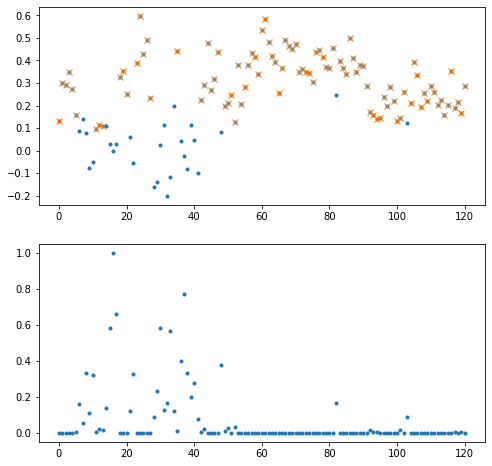

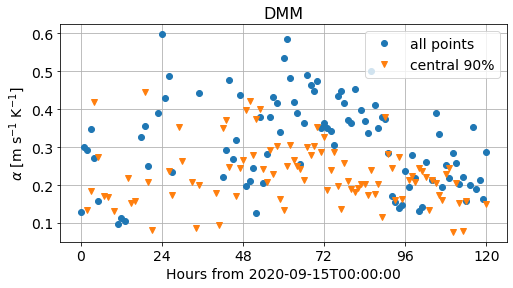

In [41]:
# Plot the time series of the slope computed on the fixed bin distributions.
# Plot the slope with p value<0.05 - confidence level = 95%
hours = np.arange(len(ts_slope))
id_conf = (np.array(ts_p_slope)<0.05)
id_conf_sub = (np.array(ts_p_slope_sub)<0.05)

fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(2, 1, 1)
ax0.plot(hours,ts_slope,'.')
ax0.plot(hours[id_conf],ts_slope[id_conf],'x')
ax1 = fig.add_subplot(2, 1, 2)
ax1.plot(ts_p_slope,'.')


fig = plt.figure(figsize=(8,4))
ax0 = fig.add_subplot(111)

ax0.plot(hours[id_conf],ts_slope[id_conf],'o')
ax0.plot(hours[id_conf_sub],ts_slope_sub[id_conf_sub],'v')
ax0.set_xlabel('Hours from ' + str_start,fontsize=14)
ax0.set_ylabel('$\\alpha$ ['+alpha_units+']',fontsize=14)
ax0.grid()
ax0.tick_params(axis='both',labelsize=14)
ax0.set_xticks([0,24,48,72,96,120])
ax0.set_title(mech,fontsize=16)
plt.legend(['all points','central 90%'],fontsize=14)

figure_name = 'time_series_slope_' + str_a + '_' + str_b + '_sigma'+str(sigma)+'_'+exp+ '.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight')

Text(0.5, 1.0, 'slope = 0.295 m s$^{-1}$ K$^{-1}$, p = 0.00\nslope_sub = 0.206 m s$^{-1}$ K$^{-1}$, p = 0.00')

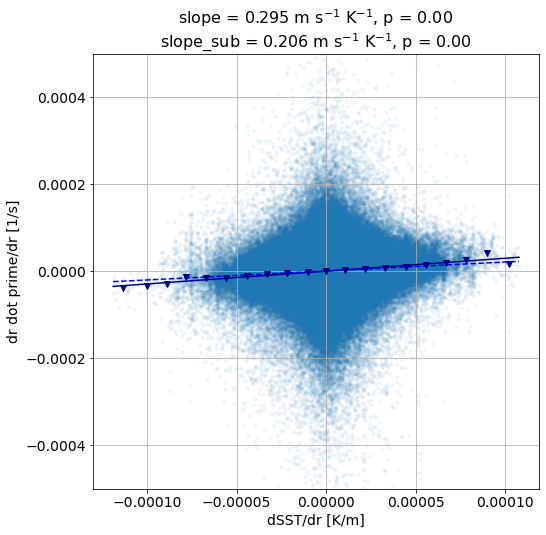

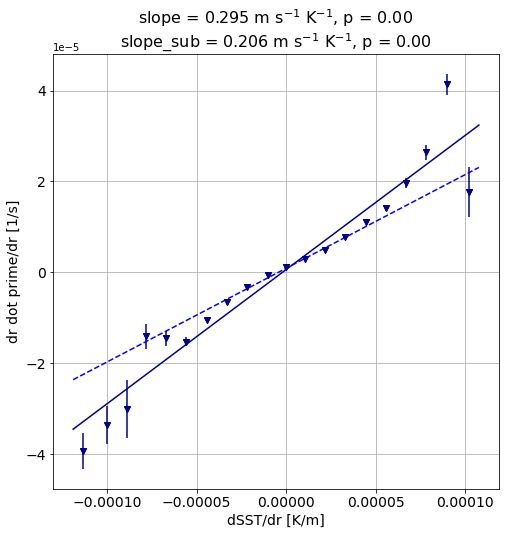

In [42]:
# Plot the distributions.
perc_step = 5

a[np.isinf(a)] = np.nan
b[np.isinf(b)] = np.nan

threshold_number = 1e3

plt.figure(figsize=(8,8))
if mech=='DMM':
    if exp=='SMT':
        thA =2e-6
    else:
        thA = 2e-5
elif mech=='PA':
    if exp=='SMT':
        thA = 2e-10
    else:
        thA = 2e-9
        
slope, intercept, sr_distr, p_value, distribution_control_fb, distribution_fb, std_distribution_fb, rvalue, p_slope, number_of_points_fb = dstr.metrics_fixed_bin_distribution(a,b,perc_step)        
sub_slope, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx, r_posx, sub_slope_p = nonlinear_metrics(distribution_control_fb,distribution_fb,number_of_points_fb, threshold_number)
        
#plt.scatter(a[(a>thA)|(a<-thA)],b[(a>thA)|(a<-thA)],alpha=0.1,marker='.')
plt.scatter(a.flatten(),b.flatten(),alpha=0.05,marker='.')
ics = np.array([np.min(a),np.max(a)])
ipsilon = slope*ics + intercept
plt.plot(ics, ipsilon, 'darkblue')
plt.plot(ics, ics*sub_slope+sub_intercept,'--', color='blue')
plt.errorbar(distribution_control_fb,distribution_fb,std_distribution_fb/np.sqrt(number_of_points_fb),fmt='v',color='darkblue')
plt.ylabel(y_string,fontsize=14)
plt.xlabel(x_string,fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.grid()
plt.ylim([-5e-4,5e-4])
#plt.title('slope = '+ "{:4.3f}".format(slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(p_slope), fontsize=16)
plt.title('slope = '+ "{:4.3f}".format(slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(p_slope) +
          '\nslope_sub = '+ "{:4.3f}".format(sub_slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(sub_slope_p), fontsize=16)


plt.figure(figsize=(8,8))
plt.plot(ics, ipsilon, 'darkblue')
plt.plot(ics, ics*sub_slope+sub_intercept,'--', color='blue')
plt.plot(distribution_control_fb,distribution_fb,'v',color='darkblue')
plt.errorbar(distribution_control_fb,distribution_fb,std_distribution_fb/np.sqrt(number_of_points_fb),fmt='v',color='darkblue')
plt.ylabel(y_string,fontsize=14)
plt.xlabel(x_string,fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.grid()
plt.title('slope = '+ "{:4.3f}".format(slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(p_slope) +
          '\nslope_sub = '+ "{:4.3f}".format(sub_slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(sub_slope_p), fontsize=16)


#figure_name = 'scatter_plot_' + str_a + '_' + str_b + '_'+exp+ '.png'
#plt.savefig('./figures/'+figure_name,bbox_inches='tight')

/home/agostino/miniconda3/envs/eureca/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


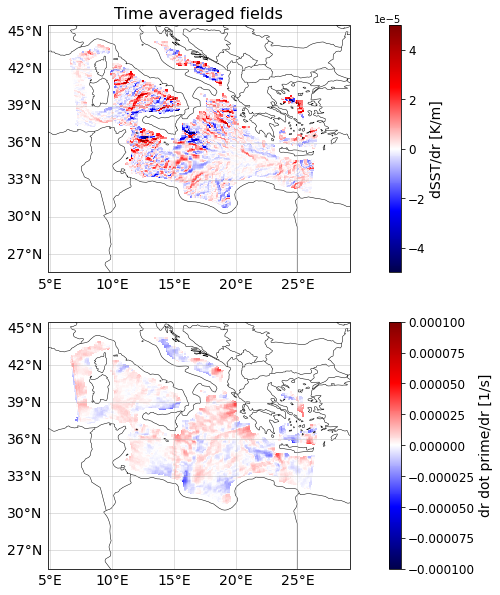

In [43]:
# Look at the time-averaged fields

fig = plt.figure(figsize=(14,10))

ax0 = fig.add_subplot(2, 1, 1, projection=crs)
plot_background(ax0)
pc0 = ax0.pcolormesh(lon,lat,a_timeavg*seamask,vmin=vmin_a,vmax=vmax_a,shading='nearest',
                   transform=ccrs.PlateCarree(),cmap='seismic')
cbar0 = plt.colorbar(pc0)
cbar0.ax.tick_params(labelsize=12) 
cbar0.set_label(x_string,size=14)
#ax0.set_extent(extent_zoom)

ax1 = fig.add_subplot(2, 1, 2, projection=crs)
plot_background(ax1)
pc1 = ax1.pcolormesh(lon,lat,b_timeavg*seamask,vmin=vmin_b,vmax=vmax_b,shading='nearest',
                     transform=ccrs.PlateCarree(),cmap='seismic')
cbar1 = plt.colorbar(pc1)
cbar1.ax.tick_params(labelsize=12) 
cbar1.set_label(y_string,size=14)
#ax1.set_extent(extent_zoom)

ax0.set_title('Time averaged fields',fontsize=16)

figure_name = 'map_'+str_a+'_'+str_b+'_timeavg_sigma'+str(sigma)+'_'+exp+ '.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight')

In [44]:
# The fact that dr_dot_prime_dr is positive along the track might be linked to the asymmetry in the Medicane: it
# has stronger wind on the westward side: can this be related to the meridional SST gradient?

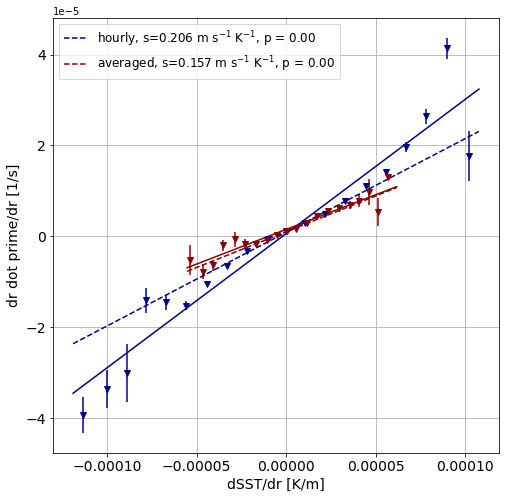

In [45]:
# Plot the distributions.
perc_step = 5
str_title = 'one day' 
str_name = 'one_day_wrfout_sigma' + str(sigma)
# Set the xlim and ylim for the mixed distribution figure.
xlimiti=np.nan; ylimiti=np.nan

# Hourly data.
a[np.isinf(a)] = np.nan
b[np.isinf(b)] = np.nan
#dstr.mixed_distribution_with_hist(a,b,str_a,str_b,xlimiti,ylimiti,x_string,y_string,perc_step,title=str_title,str_name=str_name)

plt.figure(figsize=(8,8))
if mech=='DMM':
    if exp=='SMT':
        thA =2e-6
    else:
        thA = 2e-5
elif mech=='PA':
    if exp=='SMT':
        thA = 2e-10
    else:
        thA = 2e-9
#plt.scatter(a[(a>thA)|(a<-thA)],b[(a>thA)|(a<-thA)],alpha=0.1,marker='.') # PA
#plt.scatter(a.flatten(),b.flatten(),alpha=0.1,marker='.')
slope, intercept, sr_distr, p_value, distribution_control_fb, distribution_fb, std_distribution_fb, rvalue, p_slope, number_of_points_fb = dstr.metrics_fixed_bin_distribution(a,b,perc_step)
sub_slope, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx, r_posx, sub_slope_p = nonlinear_metrics(distribution_control_fb,distribution_fb,number_of_points_fb, threshold_number)

ics = np.array([np.min(a),np.max(a)])
ipsilon = slope*ics + intercept
plt.plot(ics, ipsilon, 'darkblue')
#         label='hourly, s='+ "{:4.3f}".format(slope)+ ' ' + alpha_units + ', p='+"{:3.2f}".format(p_slope)+ 
#         '\nSpearman r='+"{:3.2f}".format(sr_distr)+ ', p='+"{:3.2f}".format(p_value))
plt.plot(ics, ics*sub_slope + sub_intercept,'--',color='darkblue',
         label='hourly, s='+ "{:4.3f}".format(sub_slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(sub_slope_p))         
plt.errorbar(distribution_control_fb,distribution_fb,std_distribution_fb/np.sqrt(number_of_points_fb),fmt='v',color='darkblue')
plt.ylabel(y_string,fontsize=14)
plt.xlabel(x_string,fontsize=14)
plt.tick_params(axis='both', labelsize=14)
#plt.grid()
#plt.title('slope = '+ "{:4.3f}".format(slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(p_slope), fontsize=16)

# Time-averaged data.
a_sub_ta = gm.crop_field(a_timeavg,lon,lat,extent)#_zoom)
b_sub_ta = gm.crop_field(b_timeavg,lon,lat,extent)#_zoom)

idnan = (~np.isnan(a_sub_ta)&(~np.isnan(b_sub_ta)))
a_ta, b_ta = a_sub_ta[idnan], b_sub_ta[idnan]

a_ta[np.isinf(a_ta)] = np.nan
b_ta[np.isinf(b_ta)] = np.nan

#plt.scatter(a_ta[(a_ta>thA)|(a_ta<-thA)],b_ta[(a_ta>thA)|(a_ta<-thA)],c='red',alpha=0.1,marker='x') # PA
#plt.scatter(a_ta.flatten(),b_ta.flatten(),alpha=0.1,marker='x')
slope, intercept, sr_distr, p_value, distribution_control_fb, distribution_fb, std_distribution_fb, rvalue, p_slope, number_of_points_fb = dstr.metrics_fixed_bin_distribution(a_ta,b_ta,perc_step)
sub_slope, sub_intercept, mdiff, mdiff_negx, mdiff_posx, x5, x95, r_negx, r_posx, sub_slope_p = nonlinear_metrics(distribution_control_fb,distribution_fb,number_of_points_fb, threshold_number)

ics = np.array([np.min(a_ta),np.max(a_ta)])
ipsilon = slope*ics + intercept
plt.plot(ics, ipsilon, 'darkred')
#         label='hourly, s='+ "{:4.3f}".format(slope)+ ' ' + alpha_units + ', p='+"{:3.2f}".format(p_slope)+ 
#         '\nSpearman r='+"{:3.2f}".format(sr_distr)+ ', p='+"{:3.2f}".format(p_value))
plt.plot(ics, ics*sub_slope + sub_intercept,'--',color='darkred',
         label='averaged, s='+ "{:4.3f}".format(sub_slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(sub_slope_p))
plt.errorbar(distribution_control_fb,distribution_fb,std_distribution_fb/np.sqrt(number_of_points_fb),fmt='v',color='darkred')
plt.ylabel(y_string,fontsize=14)
plt.xlabel(x_string,fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.grid()
plt.legend(fontsize=12)
#plt.title('slope = '+ "{:4.3f}".format(slope)+ ' ' + alpha_units + ', p = '+"{:3.2f}".format(p_slope), fontsize=16)

figure_name = 'scatter_plot_' + str_a + '_' + str_b + '_sigma'+str(sigma)+'_'+exp+ '.png'
plt.savefig('./figures/'+figure_name,bbox_inches='tight')

